# Heart Disease EDA

This notebook performs a comprehensive exploratory data analysis (EDA) on the dataset to surface structure, data quality, distributions, relationships, and feature importance insights.

What you'll get:
- Dataset overview (shape, dtypes, missingness)
- Visual distributions for numeric and categorical features
- Target balance and metrics
- Correlations and mutual information with target
- Quick model-based feature importances (LogReg + RandomForest)
- Outlier checks
- Actionable insights summary

In [4]:
# Imports & settings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Detect project root and candidate data paths
NB_DIR = Path.cwd()
CANDIDATES = [
    NB_DIR / "final.csv",               # if EDA is at repo root (unlikely here)
    NB_DIR.parent / "final.csv",        # repo root
    NB_DIR / "draft" / "final.csv"      # local draft copy
]

# Load data robustly
for p in CANDIDATES:
    if p.exists():
        data_path = p
        break
else:
    raise FileNotFoundError(f"Could not find final.csv in any of: {[str(p) for p in CANDIDATES]}")

df = pd.read_csv(data_path)
print("Loaded:", data_path)
print("Shape:", df.shape)
df.head(3)

Loaded: /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/final.csv
Shape: (319795, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


In [5]:
# Structure, types, and missing values overview
def missing_summary(frame: pd.DataFrame) -> pd.DataFrame:
    miss = frame.isna().sum().sort_values(ascending=False)
    pct = (miss / len(frame)).round(4)
    out = pd.DataFrame({"missing": miss, "missing_pct": pct})
    return out[out["missing"] > 0]

print("\nDtypes:")
print(df.dtypes.value_counts())

print("\nMemory usage (MB):", round(df.memory_usage(deep=True).sum() / (1024**2), 2))

print("\nMissing values summary:")
display(missing_summary(df).head(20))

# Basic describe for numeric and object
print("\nDescribe (numeric):")
display(df.describe())
print("\nDescribe (categorical):")
display(df.describe(include=["object"]))


Dtypes:
object     14
float64     4
Name: count, dtype: int64

Memory usage (MB): 267.01

Missing values summary:


,missing,missing_pct



Describe (numeric):


,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000



Describe (categorical):


,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
count,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795,319795
unique,2,2,2,2,2,2,13,6,4,2,5,2,2,2
top,No,No,No,No,No,Female,65-69,White,No,Yes,Very good,No,No,No
freq,292422,187887,298018,307726,275385,167805,34151,245212,269653,247957,113858,276923,308016,289976


Target column: HeartDisease
HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64
Mapped target 'No'/'Yes' -> 0/1


/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/1744913754.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette="Set2")


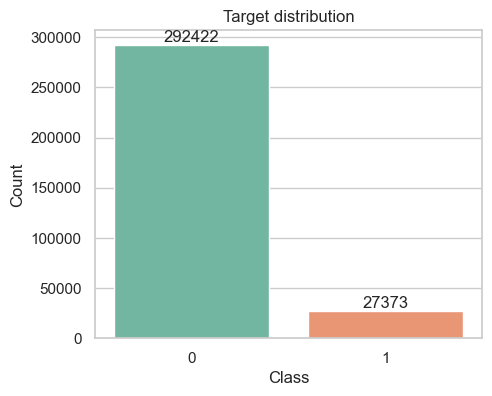

Class ratio (positive %): 8.56 %


In [6]:
# Identify target column
candidate_targets = ["HeartDisease", "target", "Outcome", "label"]
found_target = None
for c in candidate_targets:
    if c in df.columns:
        found_target = c
        break
if found_target is None:
    raise KeyError(f"Could not find a target column in candidates: {candidate_targets}. Columns: {list(df.columns)[:10]}...")

target_col = found_target
print("Target column:", target_col)
print(df[target_col].value_counts(dropna=False))

# Normalize binary labels to 0/1 if strings like 'Yes'/'No'
if df[target_col].dtype == 'object':
    mapped = df[target_col].map({'No': 0, 'Yes': 1})
    if mapped.notna().all():
        df[target_col] = mapped.astype(int)
        print("Mapped target 'No'/'Yes' -> 0/1")

# Class balance plot
counts = df[target_col].value_counts()
plt.figure(figsize=(5,4))
sns.barplot(x=counts.index.astype(str), y=counts.values, palette="Set2")
plt.title("Target distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

print("Class ratio (positive %):", round(100 * counts.get(1, 0) / counts.sum(), 2), "%")

In [7]:
# Numeric and categorical splits
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)
cat_cols = [c for c in df.columns if c not in num_cols + [target_col]]
print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

Numeric cols: 4
Categorical cols: 13


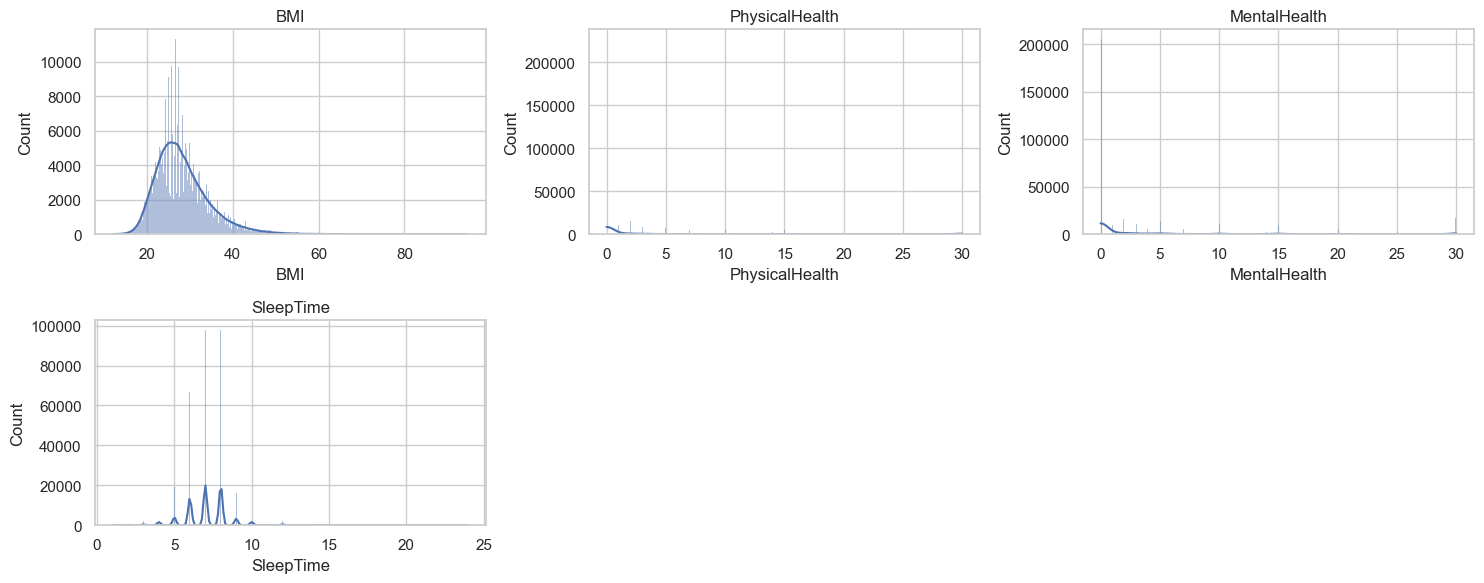

In [8]:
# Histograms for numeric features
import math
n = len(num_cols)
if n:
    cols = 3
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
    axes = axes.flatten() if n > 1 else [axes]
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], kde=True, ax=axes[i], color="#4C72B0")
        axes[i].set_title(col)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns to plot")

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


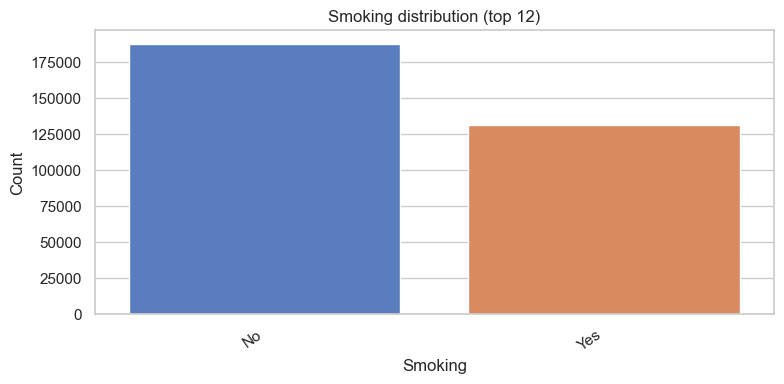

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


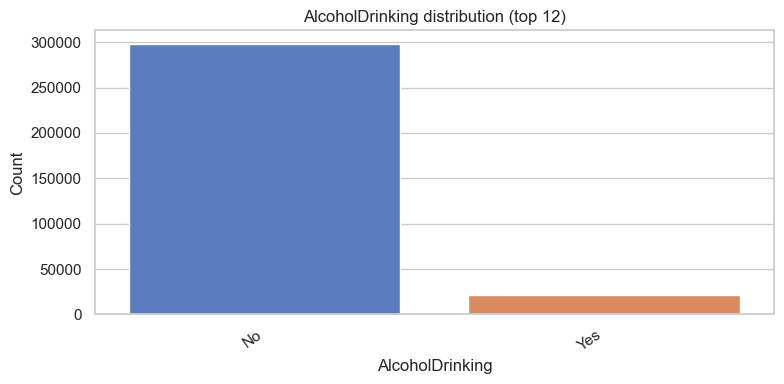

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


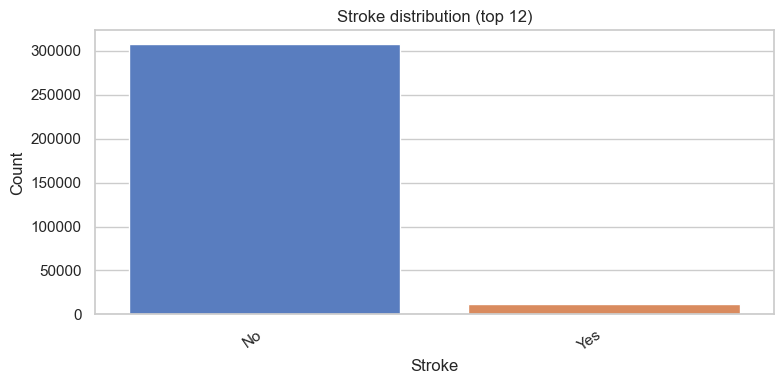

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


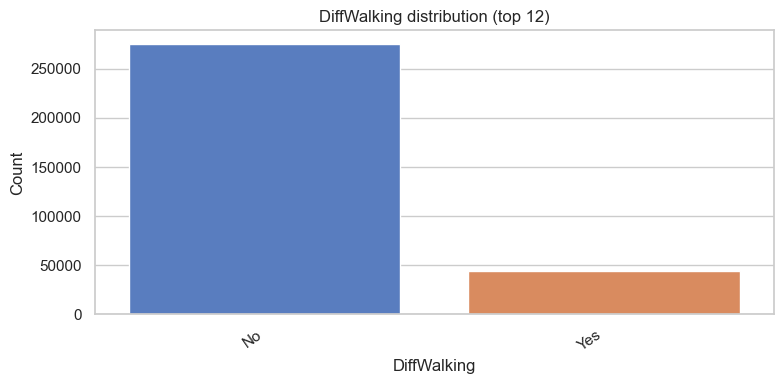

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


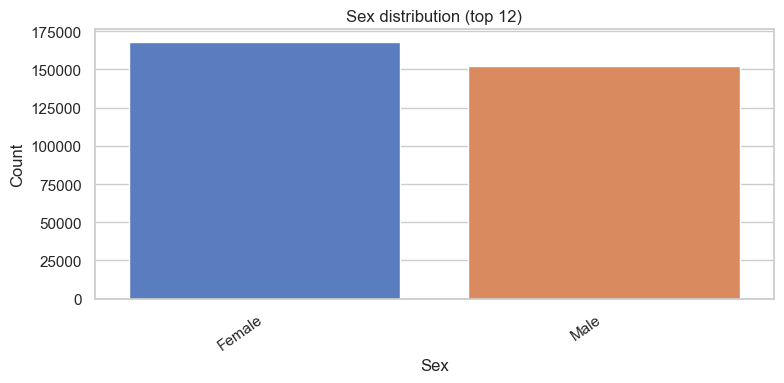

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


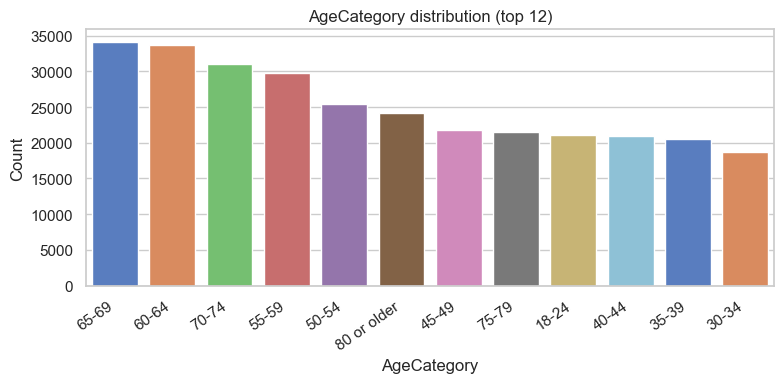

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


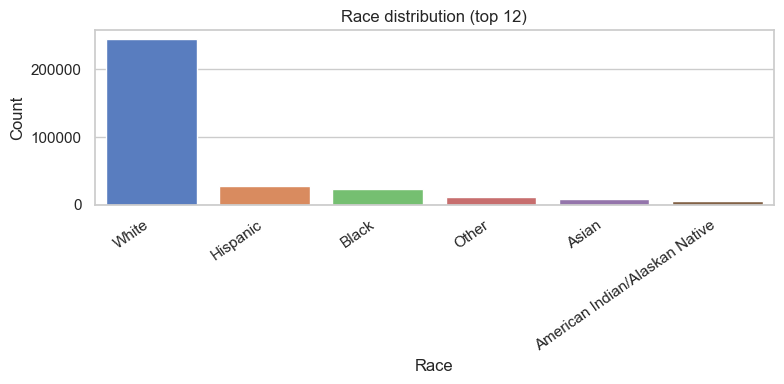

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


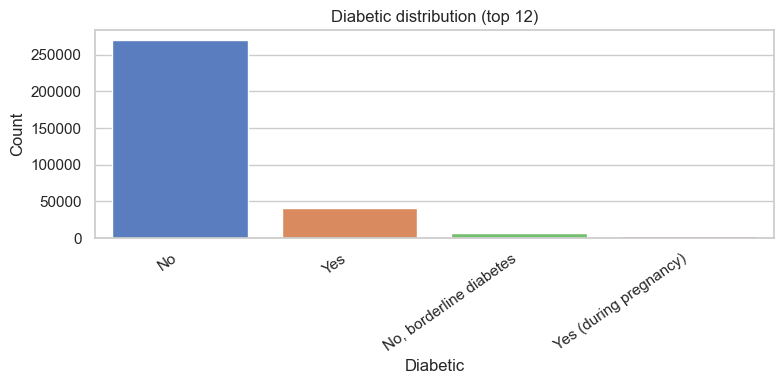

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


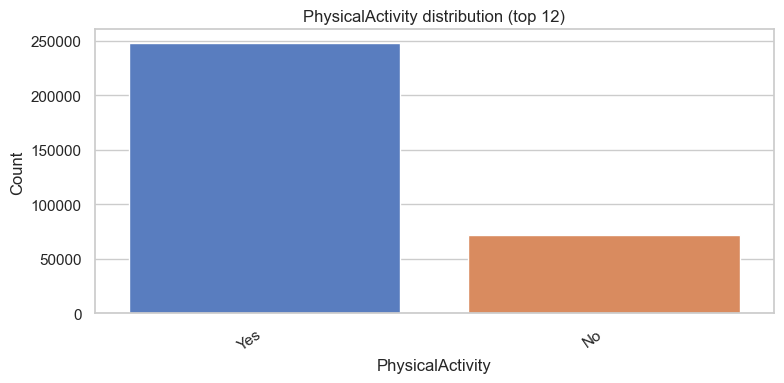

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


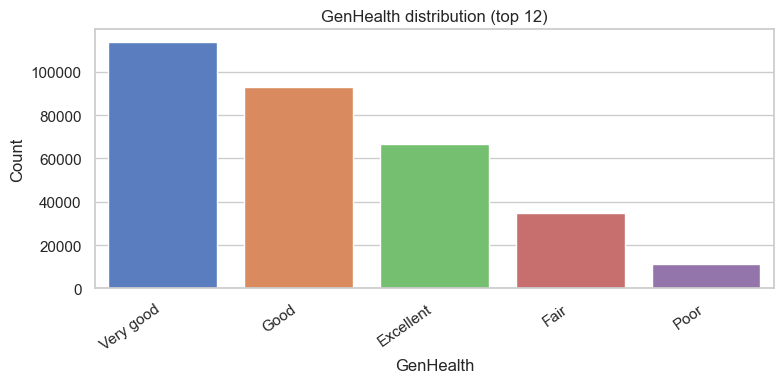

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


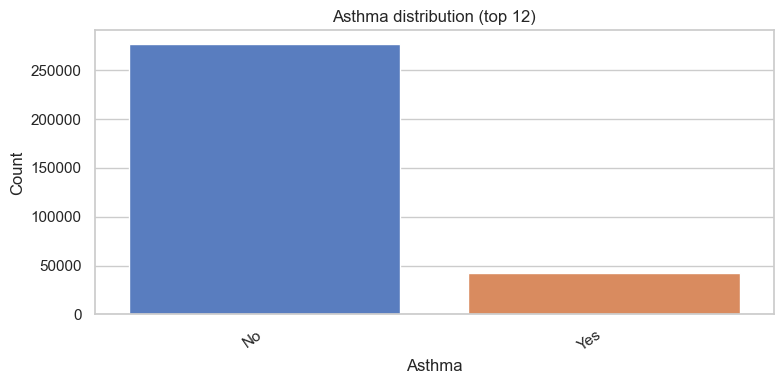

/var/folders/gd/l7qfl_t91_78hcdr2hzfzpmw0000gn/T/ipykernel_74418/2641417208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")


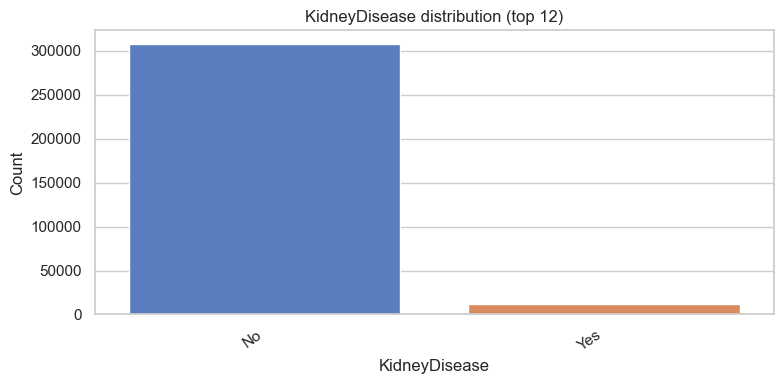

In [9]:
# Bar plots for top categorical features (by cardinality)
max_show = 12
for col in cat_cols[:12]:
    plt.figure(figsize=(8,4))
    vc = df[col].value_counts(dropna=False).head(max_show)
    sns.barplot(x=vc.index.astype(str), y=vc.values, palette="muted")
    plt.title(f"{col} distribution (top {max_show})")
    plt.xticks(rotation=35, ha='right')
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

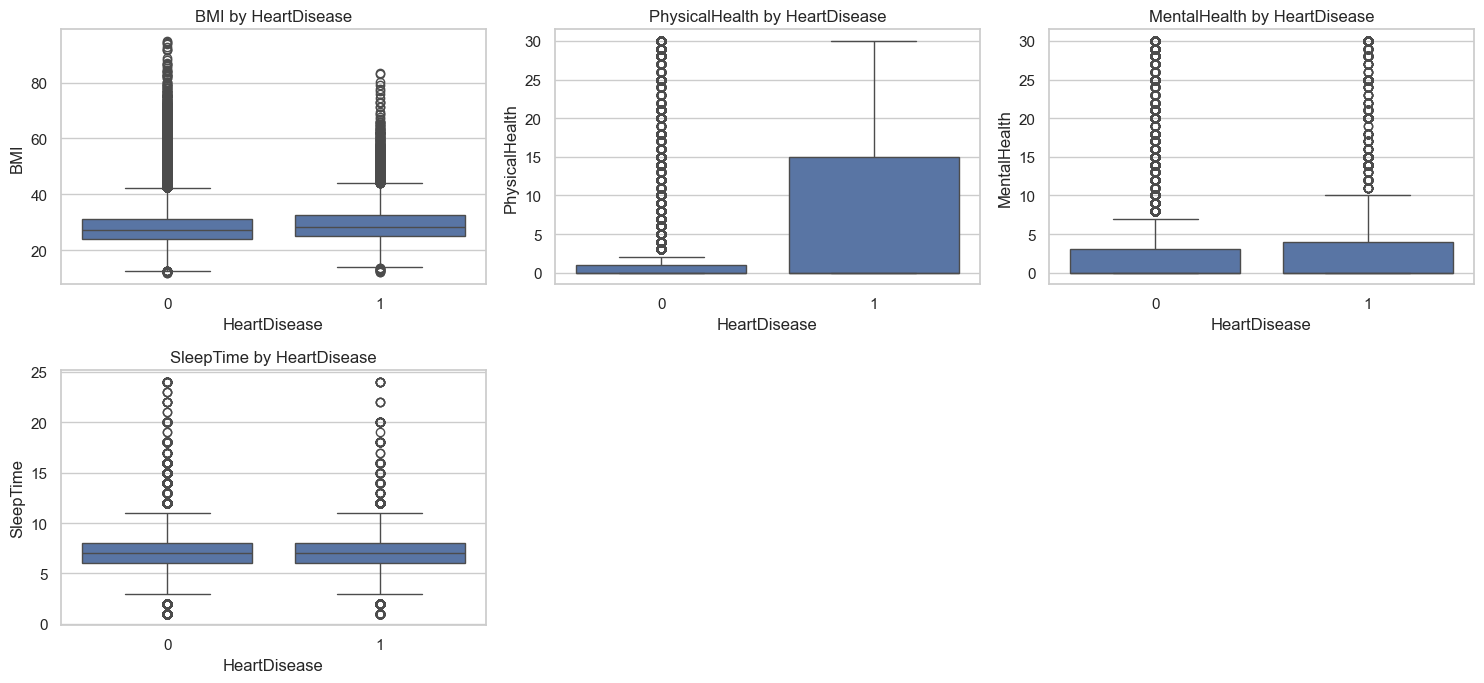

In [10]:
# Numeric vs target: boxplots
if num_cols:
    n = len(num_cols)
    cols = 3
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3.5))
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        sns.boxplot(data=df, x=target_col, y=col, ax=axes[i])
        axes[i].set_title(f"{col} by {target_col}")
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns for boxplots")

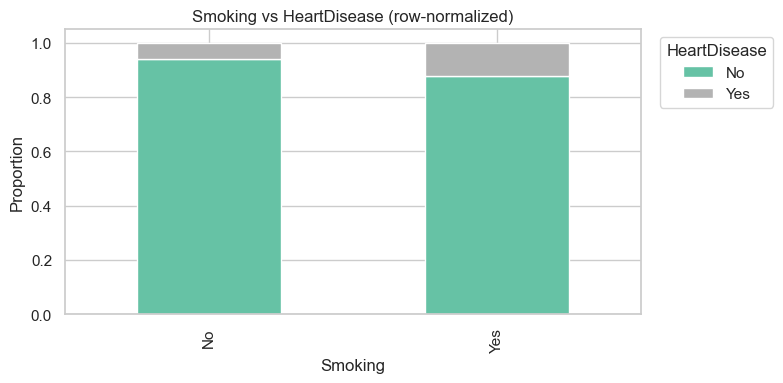

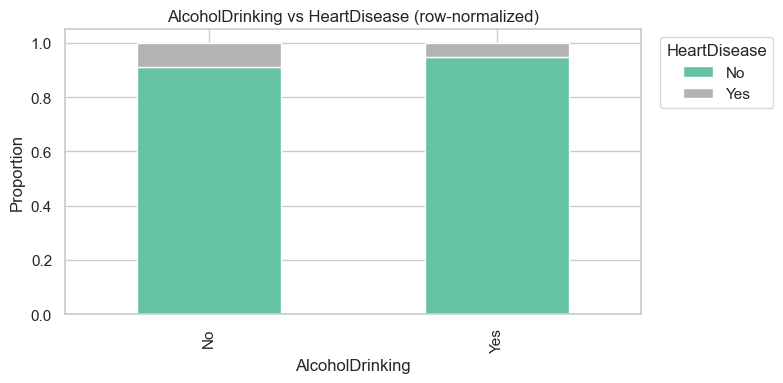

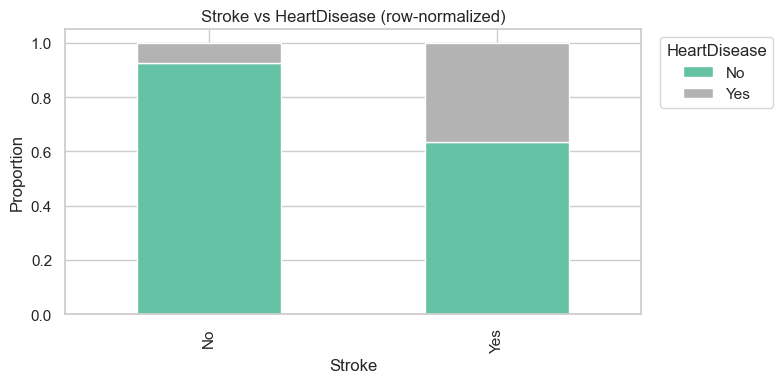

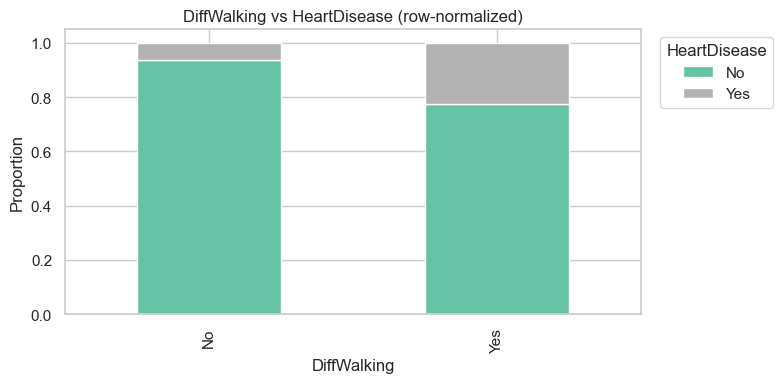

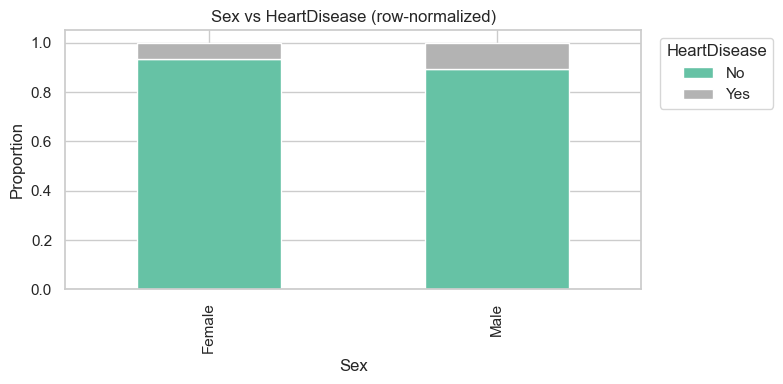

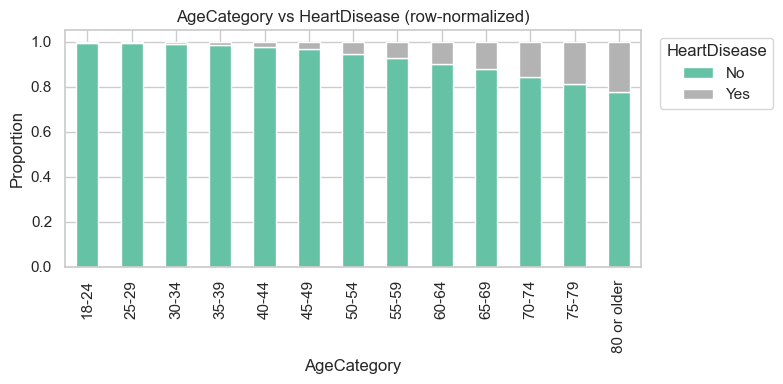

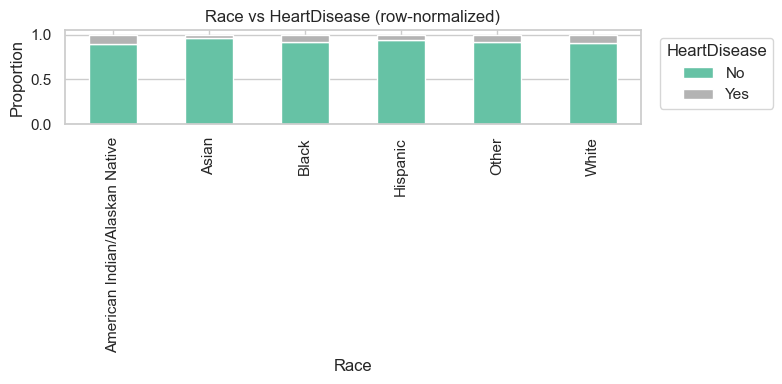

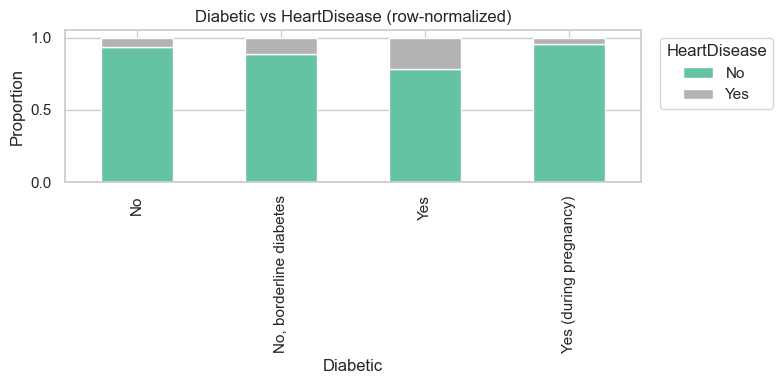

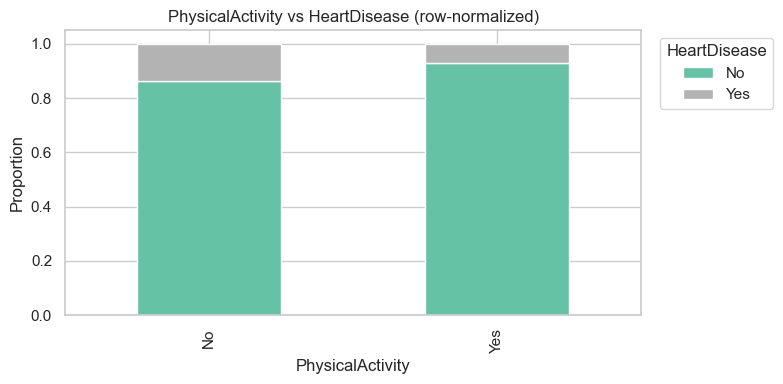

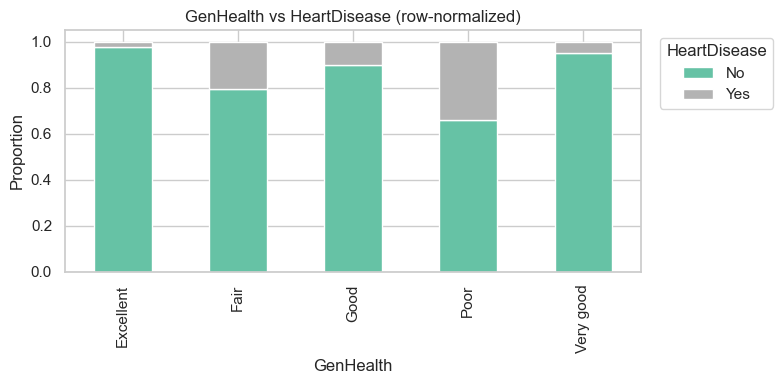

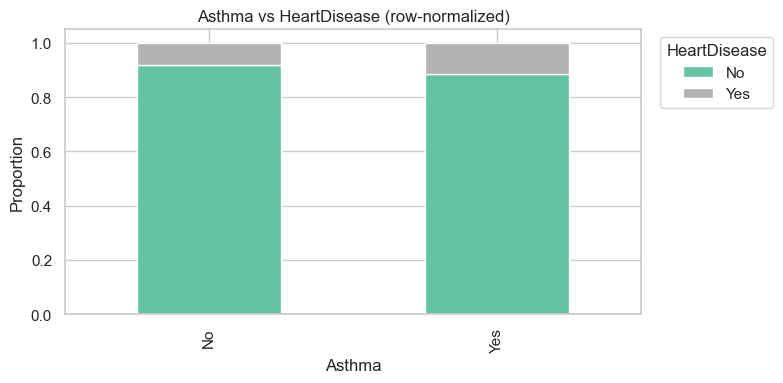

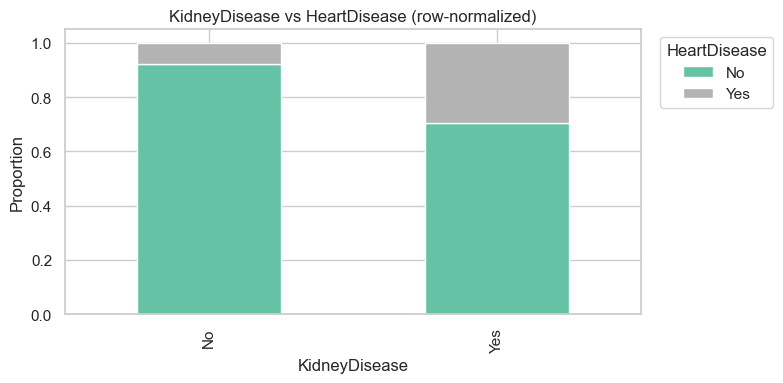

In [11]:
# Categorical vs target: stacked proportions
import itertools
for col in cat_cols[:12]:
    ct = (pd.crosstab(df[col], df[target_col], normalize='index')
            .rename(columns={0:'No', 1:'Yes'}))
    ct.plot(kind='bar', stacked=True, figsize=(8,4), colormap='Set2')
    plt.title(f"{col} vs {target_col} (row-normalized)")
    plt.ylabel("Proportion")
    plt.legend(title=target_col, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

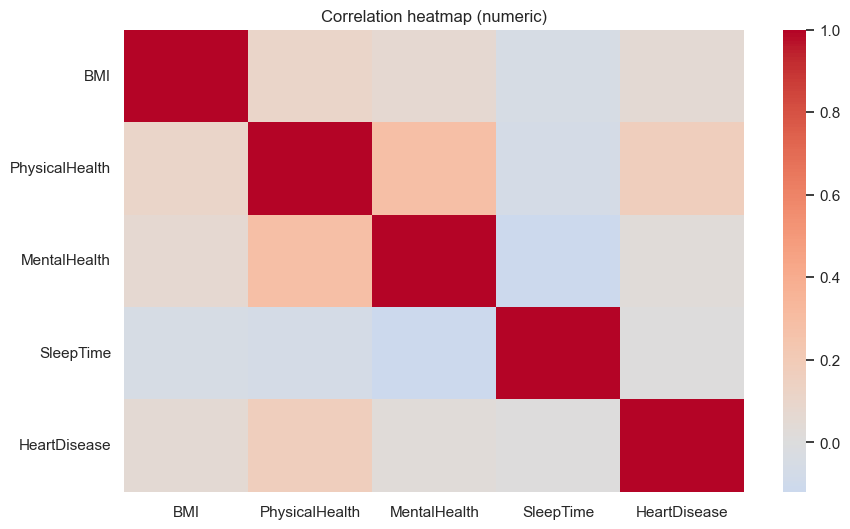

Top correlations with target:


PhysicalHealth    0.170721
BMI               0.051803
MentalHealth      0.028591
SleepTime         0.008327
Name: HeartDisease, dtype: float64

In [12]:
# Correlation matrix (numeric only) and top correlations with target
num_df = df[num_cols + [target_col]].copy()
cor = num_df.corr(numeric_only=True)
sns.heatmap(cor, cmap='coolwarm', center=0)
plt.title('Correlation heatmap (numeric)')
plt.show()

if target_col in cor.columns:
    target_corr = (cor[target_col].drop(target_col).abs()
                   .sort_values(ascending=False))
    print("Top correlations with target:")
    display(target_corr.head(20))
else:
    print("Target not in correlation matrix (non-numeric)")

Top features by Mutual Information with target:


Stroke_No                  0.078250
KidneyDisease_No           0.073118
DiffWalking_No             0.071476
Diabetic_No                0.070061
PhysicalActivity_Yes       0.064911
Smoking_No                 0.061610
Race_White                 0.058786
Asthma_No                  0.053116
SkinCancer_No              0.051137
Sex_Female                 0.051031
AlcoholDrinking_No         0.042423
Sex_Male                   0.040523
Smoking_Yes                0.034050
GenHealth_Very good        0.029945
SleepTime                  0.019722
DiffWalking_Yes            0.018228
GenHealth_Excellent        0.017468
Diabetic_Yes               0.015628
GenHealth_Good             0.014949
PhysicalHealth             0.012981
Stroke_Yes                 0.011998
PhysicalActivity_No        0.011947
GenHealth_Fair             0.010346
GenHealth_Poor             0.010171
AgeCategory_80 or older    0.008127
dtype: float64

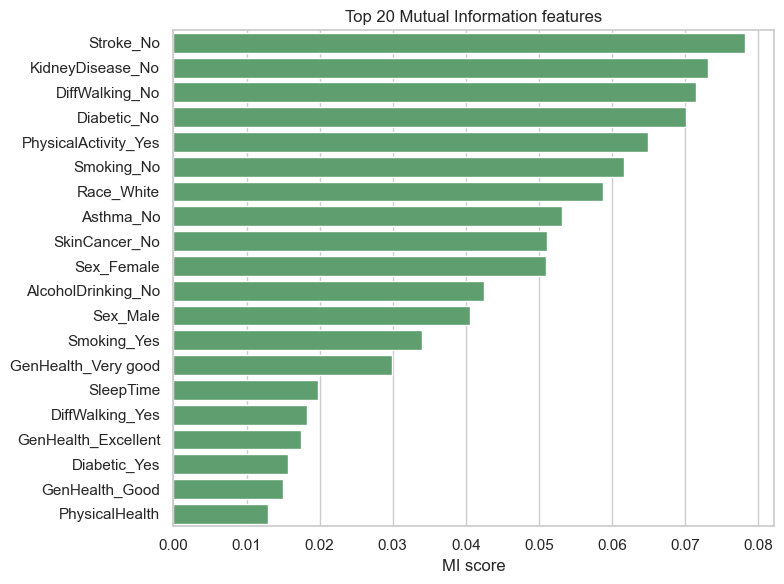

In [14]:
# Mutual Information (captures non-linear relationships)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

X = df.drop(columns=[target_col])
y = df[target_col].values

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_features),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_features)
])

X_enc = pre.fit_transform(X)
mi = mutual_info_classif(X_enc, y, discrete_features=False, random_state=42)

# Build feature names after OHE
cat_names = []
if cat_features:
    oh = pre.named_transformers_["cat"].named_steps["oh"]
    cat_names = oh.get_feature_names_out(cat_features).tolist()
feature_names = num_features + cat_names

mi_series = pd.Series(mi, index=feature_names).sort_values(ascending=False)
print("Top features by Mutual Information with target:")
display(mi_series.head(25))

plt.figure(figsize=(8,6))
sns.barplot(x=mi_series.head(20), y=mi_series.head(20).index, orient='h', color="#55A868")
plt.title("Top 20 Mutual Information features")
plt.xlabel("MI score")
plt.ylabel("")
plt.tight_layout()
plt.show()

Top 20 LR absolute coefficients:


AgeCategory_80 or older    1.573605
AgeCategory_18-24          1.546778
AgeCategory_25-29          1.451683
AgeCategory_75-79          1.332944
AgeCategory_30-34          1.201048
AgeCategory_70-74          1.129131
AgeCategory_35-39          1.118347
GenHealth_Excellent        1.085943
GenHealth_Poor             0.860550
AgeCategory_65-69          0.841391
Stroke_No                  0.697866
AgeCategory_40-44          0.654336
GenHealth_Very good        0.597442
AgeCategory_60-64          0.595552
Sex_Female                 0.534240
GenHealth_Fair             0.472463
KidneyDisease_No           0.472024
Race_Asian                 0.401478
Smoking_No                 0.350134
Stroke_Yes                 0.343331
dtype: float64

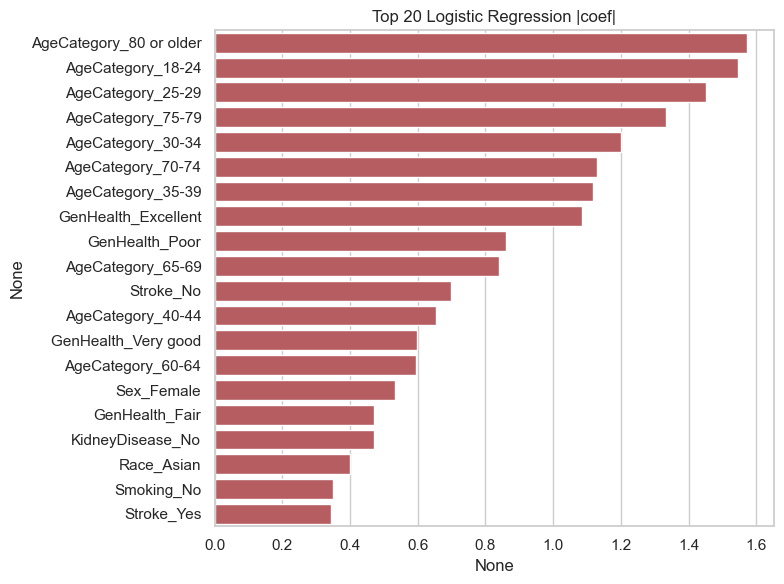

Top 20 RandomForest feature importances:


BMI                        0.338517
SleepTime                  0.109805
PhysicalHealth             0.077425
MentalHealth               0.067022
AgeCategory_80 or older    0.017128
Stroke_No                  0.014785
PhysicalActivity_No        0.014275
PhysicalActivity_Yes       0.014233
DiffWalking_Yes            0.014212
Stroke_Yes                 0.013976
Diabetic_Yes               0.013967
DiffWalking_No             0.013663
AgeCategory_70-74          0.013160
Race_White                 0.013085
GenHealth_Fair             0.013037
AgeCategory_75-79          0.012952
GenHealth_Poor             0.012631
Asthma_No                  0.011805
Asthma_Yes                 0.011794
AgeCategory_65-69          0.011600
dtype: float64

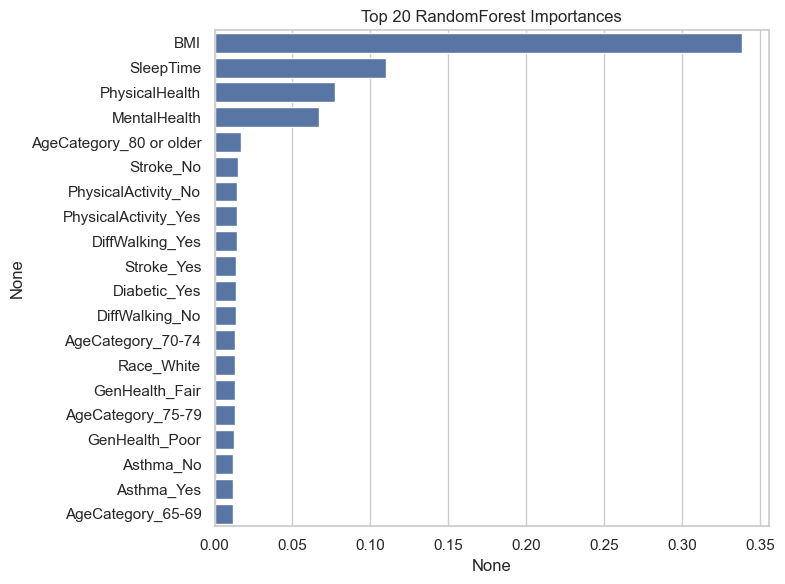

In [15]:
# Quick model-based feature importance: Logistic Regression (L2) & RandomForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use the preprocessed X_enc and names from previous cell
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver='lbfgs')
lr.fit(X_train, y_train)
coef = pd.Series(np.abs(lr.coef_[0]), index=feature_names).sort_values(ascending=False)
print("Top 20 LR absolute coefficients:")
display(coef.head(20))
plt.figure(figsize=(8,6))
sns.barplot(x=coef.head(20), y=coef.head(20).index, orient='h', color="#C44E52")
plt.title("Top 20 Logistic Regression |coef|")
plt.tight_layout()
plt.show()

# RandomForest
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("Top 20 RandomForest feature importances:")
display(imp.head(20))
plt.figure(figsize=(8,6))
sns.barplot(x=imp.head(20), y=imp.head(20).index, orient='h', color="#4C72B0")
plt.title("Top 20 RandomForest Importances")
plt.tight_layout()
plt.show()

Top outlier-heavy numeric features:


,feature,outliers
2,MentalHealth,51576
1,PhysicalHealth,47146
0,BMI,10396
3,SleepTime,4543


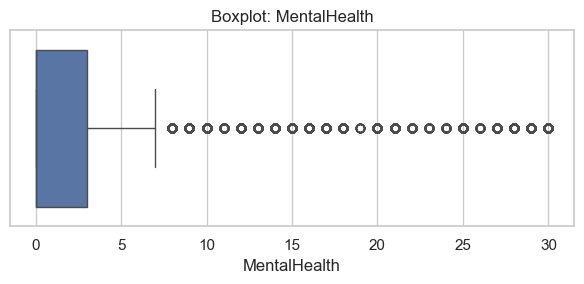

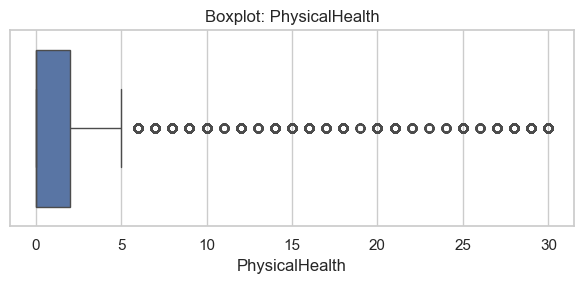

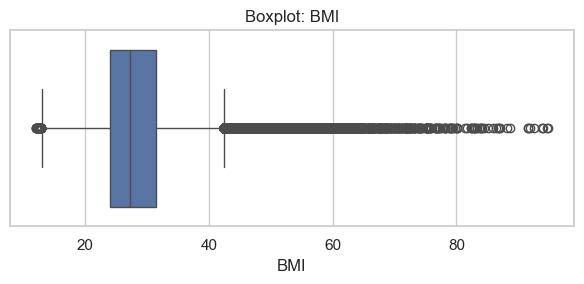

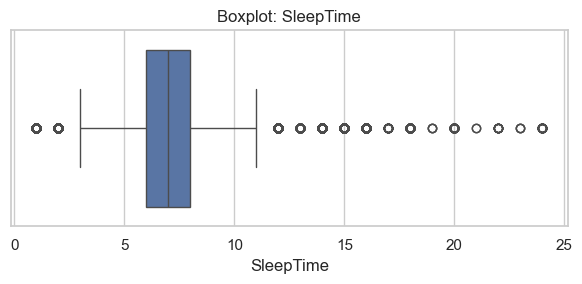

In [16]:
# Outlier check (IQR method) for numeric columns
from collections import defaultdict
outlier_counts = defaultdict(int)

for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_counts[col] = int(mask.sum())

outliers_df = pd.DataFrame({"feature": list(outlier_counts.keys()), "outliers": list(outlier_counts.values())})
outliers_df = outliers_df.sort_values("outliers", ascending=False)
print("Top outlier-heavy numeric features:")
display(outliers_df.head(20))

# Example boxplots for a few most outlier-prone features
for col in outliers_df.head(6)["feature"]:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

## Insights and notes

- Class balance: Inspect the target distribution above for imbalance; consider resampling or class weights if positive rate is low.
- Strong drivers: See the Mutual Information, Logistic Regression coefficients, and RandomForest importances for the most predictive features.
- Numeric relationships: Boxplots vs target highlight shifts between classes.
- Categorical effects: Stacked bars show how category choices associate with outcomes.
- Outliers: Review outlier-heavy features; cap/winsorize or transform if necessary.
- Next steps: Feed these findings into feature engineering, model choice, and evaluation thresholds.